# Creation of single application dataset and feature engineering

Based on Will Koehrsen's Kaggle Notebook, availiable at: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction/

And Pietro Marinelli's kernel : https://www.kaggle.com/poohtls/fork-of-fork-lightgbm-with-simple-features

In [1]:
# Librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce

from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer

# Options
pd.set_option('display.max_columns', 200)
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Application datasets

## Combining datasets

In [2]:
# Import datasets
df_app_test = pd.read_csv('../data/data_inputs/application_test.csv')
df_app_train = pd.read_csv('../data/data_inputs/application_train.csv')

# Indicate data origin
df_app_test['source'] = 'test'
df_app_train['source'] = 'train'

# Append application datasets
df_app = df_app_train.append(df_app_test, ignore_index=True)
df_app.shape

(356255, 123)

In [3]:
# Preview
df_app.sample(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,source
298647,445987,1.0,Cash loans,M,N,N,0,135000.0,755190.0,36459.0,675000.0,Unaccompanied,State servant,Secondary / secondary special,Single / not married,House / apartment,0.030755,-8743,-763,-3515.0,-1436,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,TUESDAY,13,0,0,0,0,1,1,Police,0.181918,0.473758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,-588.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,train
83639,197007,0.0,Cash loans,F,Y,Y,0,90000.0,239850.0,23719.5,225000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.015221,-17524,-1765,-7985.0,-1069,9.0,1,1,1,1,1,0,Sales staff,2.0,2,2,MONDAY,8,0,0,0,0,0,0,Industry: type 3,0.636958,0.497700,0.396220,0.0247,NaN,0.9806,NaN,NaN,0.000,0.1034,0.0417,NaN,0.0622,NaN,0.0221,NaN,NaN,0.0252,NaN,0.9806,NaN,NaN,0.0,0.1034,0.0417,NaN,0.0636,NaN,0.0230,NaN,NaN,0.0250,NaN,0.9806,NaN,NaN,0.00,0.1034,0.0417,NaN,0.0633,NaN,0.0224,NaN,NaN,NaN,block of flats,0.0197,Panel,No,2.0,0.0,2.0,0.0,-1194.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,train
236997,374506,1.0,Revolving loans,M,Y,N,0,225000.0,225000.0,11250.0,225000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.018801,-18296,-1530,-8015.0,-1792,14.0,1,1,0,1,0,0,Laborers,2.0,2,2,TUESDAY,11,0,0,0,0,1,1,Transport: type 4,NaN,0.606399,0.424130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,1.0,5.0,0.0,-1382.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,6.0,train
8298,109674

## Target

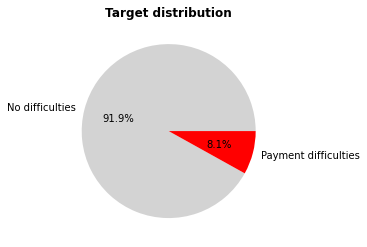

In [4]:
# Distribution in target column
plt.figure()
s_count = df_app_train.groupby('TARGET').count()['SK_ID_CURR']
plt.pie(s_count, 
        labels = ['No difficulties' if x==0 else 'Payment difficulties' for x in s_count.index], 
        colors = ['lightgrey' if x==0 else 'red' for x in s_count.index],
        autopct = lambda x: str(round(x,1))+'%'
       )
plt.title('Target distribution', fontweight = 'bold')
plt.show()

# Feature Engineering

## Categorical data

In [5]:
df_app.dtypes.value_counts()

float64    66
int64      40
object     17
dtype: int64

In [6]:
df_app.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
source                         2
dtype: int64

### Turning into binary

In [7]:
# Values for eligible features
print(df_app['FLAG_OWN_CAR'].value_counts())
print('\n')
print(df_app['FLAG_OWN_REALTY'].value_counts())
print('\n')
print(df_app['EMERGENCYSTATE_MODE'].value_counts())

N    235235
Y    121020
Name: FLAG_OWN_CAR, dtype: int64


Y    246970
N    109285
Name: FLAG_OWN_REALTY, dtype: int64


No     185607
Yes      2684
Name: EMERGENCYSTATE_MODE, dtype: int64


In [8]:
# Trabsform into boolean
df_app['FLAG_OWN_CAR'] = df_app['FLAG_OWN_CAR'].apply(lambda x: True if x=='Y' else False)
df_app['FLAG_OWN_REALTY'] = df_app['FLAG_OWN_REALTY'].apply(lambda x: True if x=='Y' else False)
df_app['EMERGENCYSTATE_MODE'] = df_app['EMERGENCYSTATE_MODE'].apply(lambda x: True if x=='Yes' else False)

### Label Encoding

In [9]:
# Values for eligible features
print(df_app['NAME_CONTRACT_TYPE'].value_counts())
print('\n')
print(df_app['CODE_GENDER'].value_counts())

Cash loans         326537
Revolving loans     29718
Name: NAME_CONTRACT_TYPE, dtype: int64


F      235126
M      121125
XNA         4
Name: CODE_GENDER, dtype: int64


In [10]:
# Exclude unknown code gender and encode
df_app = df_app[df_app['CODE_GENDER'] != 'XNA']

le = LabelEncoder()
df_app['CODE_GENDER'] = le.fit_transform(df_app['CODE_GENDER'])
df_app['NAME_CONTRACT_TYPE'] = le.fit_transform(df_app['NAME_CONTRACT_TYPE'])

In [11]:
df_app.shape

(356251, 123)

### One Hot Encoding & Binary Encoding

Binary encoding : https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02

Evaluer l'apport en performance du binary encoding vs suppression de la feature vs autre tye d'encoding (frequency / mean)

In [12]:
# Number of category per categorical feature
df_app.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
source                         2
dtype: int64

In [13]:
# One-Hot encoding for categorical features with few categories
s_sources = df_app['source']
df_occ_org = df_app['OCCUPATION_TYPE', 'ORGANIZATION_TYPE']
df_app = pd.get_dummies(df_app.drop(columns = ['source', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']))

In [17]:
# Baseline performance before encoding
from scripts import light
import re

df_app.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x), inplace = True)
light.kfold_lightgbm(df_app, num_folds = 5, stratified = True)

Starting LightGBM. Train shape: (307507, 164), test shape: (48744, 164)
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.753515	training's binary_logloss: 0.249533	valid_1's auc: 0.740234	valid_1's binary_logloss: 0.252511
[200]	training's auc: 0.77172	training's binary_logloss: 0.243026	valid_1's auc: 0.752222	valid_1's binary_logloss: 0.248291
[300]	training's auc: 0.783833	training's binary_logloss: 0.239164	valid_1's auc: 0.756635	valid_1's binary_logloss: 0.246852
[400]	training's auc: 0.794342	training's binary_logloss: 0.236087	valid_1's auc: 0.758048	valid_1's binary_logloss: 0.246381
[500]	training's auc: 0.803576	training's binary_logloss: 0.233358	valid_1's auc: 0.758718	valid_1's binary_logloss: 0.246175
[600]	training's auc: 0.811664	training's binary_logloss: 0.230875	valid_1's auc: 0.759132	valid_1's binary_logloss: 0.24605
[700]	training's auc: 0.819176	training's binary_logloss: 0.228531	valid_1's auc: 0.759282	valid_1's binary_logl

In [24]:
# Binary encoding for occupation_type and organization_type
benc = ce.BinaryEncoder(cols = ['OCCUPATION_TYPE', 'ORGANIZATION_TYPE'])
df_occ_org = benc.fit_transform(df_occ_org)

In [32]:
# Merge and evaluate performance with binary encoding
df_app = df_app.join(df_occ_org)
light.kfold_lightgbm(df_app, num_folds = 5, stratified = True)

Starting LightGBM. Train shape: (307507, 177), test shape: (48744, 177)
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.753515	training's binary_logloss: 0.249533	valid_1's auc: 0.740234	valid_1's binary_logloss: 0.252511
[200]	training's auc: 0.77188	training's binary_logloss: 0.243	valid_1's auc: 0.752281	valid_1's binary_logloss: 0.248285
[300]	training's auc: 0.783901	training's binary_logloss: 0.239152	valid_1's auc: 0.756439	valid_1's binary_logloss: 0.246884
[400]	training's auc: 0.794632	training's binary_logloss: 0.236042	valid_1's auc: 0.758131	valid_1's binary_logloss: 0.246356
[500]	training's auc: 0.803872	training's binary_logloss: 0.233306	valid_1's auc: 0.758797	valid_1's binary_logloss: 0.246119
[600]	training's auc: 0.812046	training's binary_logloss: 0.230819	valid_1's auc: 0.759093	valid_1's binary_logloss: 0.246018
[700]	training's auc: 0.819468	training's binary_logloss: 0.228492	valid_1's auc: 0.759442	valid_1's binary_loglos

In [39]:
# Frequency encoding
df_occ_org = pd.DataFrame([s_occtype, s_orgtype]).T
fe_occ = df_occ_org.groupby('OCCUPATION_TYPE').size()/len(df_occ_org)
fe_org = df_occ_org.groupby('ORGANIZATION_TYPE').size()/len(df_occ_org)
df_occ_org['OCCUPATION_TYPE'] = df_occ_org['OCCUPATION_TYPE'].map(fe_occ)
df_occ_org['ORGANIZATION_TYPE'] = df_occ_org['ORGANIZATION_TYPE'].map(fe_org)

In [41]:
# Merging frequencies and evaluate performance with frequency encoding
col_select = [x for x in df_app.columns if ('OCCUPATION_TYPE' not in x) and('ORGANIZATION_TYPE' not in x)]
df_app = df_app[col_select].join(df_occ_org)
light.kfold_lightgbm(df_app, num_folds = 5, stratified = True)

Starting LightGBM. Train shape: (307507, 166), test shape: (48744, 166)
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.753812	training's binary_logloss: 0.249467	valid_1's auc: 0.740257	valid_1's binary_logloss: 0.252512
[200]	training's auc: 0.771803	training's binary_logloss: 0.24296	valid_1's auc: 0.752348	valid_1's binary_logloss: 0.248299
[300]	training's auc: 0.784319	training's binary_logloss: 0.238976	valid_1's auc: 0.756991	valid_1's binary_logloss: 0.246804
[400]	training's auc: 0.795046	training's binary_logloss: 0.235842	valid_1's auc: 0.758629	valid_1's binary_logloss: 0.246269
[500]	training's auc: 0.804312	training's binary_logloss: 0.233135	valid_1's auc: 0.759128	valid_1's binary_logloss: 0.246103
[600]	training's auc: 0.812643	training's binary_logloss: 0.230617	valid_1's auc: 0.759519	valid_1's binary_logloss: 0.245964
[700]	training's auc: 0.820385	training's binary_logloss: 0.228236	valid_1's auc: 0.759705	valid_1's binary_log

In [15]:
df_app.shape

(356251, 178)

## Cleaning

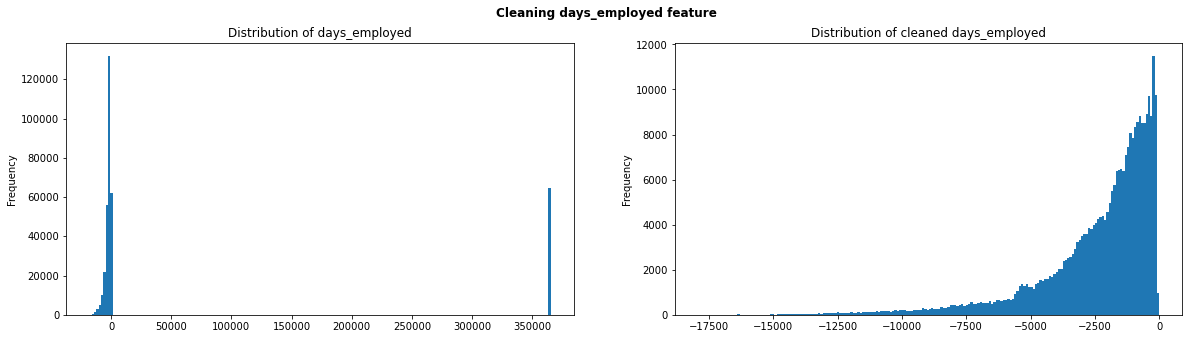

In [16]:
fig = plt.figure(figsize = (20,5))
plt.suptitle("Cleaning days_employed feature", fontweight = 'heavy')
ax1 = fig.add_subplot(121)
df_app['DAYS_EMPLOYED'].plot(kind = 'hist', bins = 200, ax = ax1)
plt.title("Distribution of days_employed")

ax2 = fig.add_subplot(122)
s_ = df_app['DAYS_EMPLOYED'].mask(df_app['DAYS_EMPLOYED'] > 50000)
s_.plot(kind = 'hist', bins = 200, ax = ax2)
plt.title("Distribution of cleaned days_employed")
plt.show()

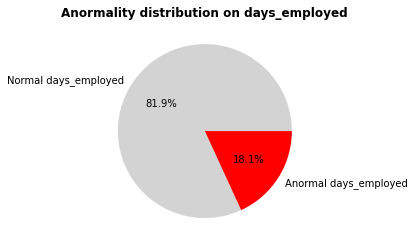

In [17]:
# Proportion of anormality and cleaning
df_app['DAYS_EMPLOYED_ANOM'] = (df_app['DAYS_EMPLOYED']>0)
df_app['DAYS_EMPLOYED'] = df_app['DAYS_EMPLOYED'].mask(df_app['DAYS_EMPLOYED'] > 0)

plt.figure()
s_count = df_app.groupby('DAYS_EMPLOYED_ANOM').count()['SK_ID_CURR']
plt.pie(s_count, 
        labels = ['Anormal days_employed' if x else 'Normal days_employed' for x in s_count.index], 
        colors = ['r' if x else 'lightgrey' for x in s_count.index],
        autopct = lambda x: str(round(x,1))+'%'
       )
plt.title('Anormality distribution on days_employed', fontweight = 'bold')
plt.show()

## Manual Feature Engineering 

In [18]:
# Creating new features
df_app['NEW_CREDIT_INCOME_PERCENT'] = df_app['AMT_CREDIT'] / df_app['AMT_INCOME_TOTAL']
df_app['NEW_CREDIT_TO_ANNUITY_RATIO'] = df_app['AMT_CREDIT'] / df_app['AMT_ANNUITY']
df_app['NEW_CREDIT_TO_GOODS_RATIO'] = df_app['AMT_CREDIT'] / df_app['AMT_GOODS_PRICE']
df_app['NEW_INC_PER_CHLD'] = df_app['AMT_INCOME_TOTAL'] / (1 + df_app['CNT_CHILDREN'])
df_app['NEW_EMPLOY_TO_BIRTH_RATIO'] = df_app['DAYS_EMPLOYED'] / df_app['DAYS_BIRTH']
df_app['NEW_ANNUITY_TO_INCOME_RATIO'] = df_app['AMT_ANNUITY'] / (1 + df_app['AMT_INCOME_TOTAL'])
df_app['NEW_SOURCES_PROD'] = df_app['EXT_SOURCE_1'] * df_app['EXT_SOURCE_2'] * df_app['EXT_SOURCE_3']
df_app['NEW_EXT_SOURCES_MEAN'] = df_app[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
df_app['NEW_SCORES_STD'] = df_app[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
df_app['NEW_SCORES_STD'] = df_app['NEW_SCORES_STD'].fillna(df_app['NEW_SCORES_STD'].mean())
df_app['NEW_CAR_TO_BIRTH_RATIO'] = df_app['OWN_CAR_AGE'] / df_app['DAYS_BIRTH']
df_app['NEW_CAR_TO_EMPLOY_RATIO'] = df_app['OWN_CAR_AGE'] / df_app['DAYS_EMPLOYED']
df_app['NEW_PHONE_TO_BIRTH_RATIO'] = df_app['DAYS_LAST_PHONE_CHANGE'] / df_app['DAYS_BIRTH']
df_app['NEW_PHONE_TO_BIRTH_RATIO_EMPLOYER'] = df_app['DAYS_LAST_PHONE_CHANGE'] / df_app['DAYS_EMPLOYED']
df_app['NEW_CREDIT_TO_INCOME_RATIO'] = df_app['AMT_CREDIT'] / df_app['AMT_INCOME_TOTAL']

docs = [c for c in df_app.columns if 'FLAG_DOC' in c]
live = [c for c in df_app.columns if ('FLAG_' in c) & ('FLAG_DOC' not in c) & ('_FLAG_' not in c)]
df_app['NEW_DOC_IND_KURT'] = df_app[docs].kurtosis(axis=1)
df_app['NEW_LIVE_IND_SUM'] = df_app[live].sum(axis=1)

In [21]:
# Income by organisation type
l_org = [c for c in df_app.columns if 'ORGANIZATION_TYPE' in c]
s_ = df_app[l_org[0]].map(str)

for col in l_org[1:]:
    s_ = s_+df_app[col].map(str)
    
df_app['temp'] = s_
inc_by_org = df_app[['AMT_INCOME_TOTAL', 'temp']].groupby('temp').median()['AMT_INCOME_TOTAL']

df_app['NEW_INC_BY_ORG'] = df_app['temp'].map(inc_by_org)
df_app.drop(columns = ['temp'], inplace = True)

# Storing new dataset

In [22]:
df_app.to_pickle('../data/data_outputs/feature_engineered/application.pkl')

Mettre en place un pipeline de données pour évaluer si l'ajout de nouvelles features apporte un plus en terme de perfs.

In [34]:
from scripts import light
import re

df_ = df_app.drop(columns = 'source').rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '',x))
light.kfold_lightgbm(df_ ,num_folds = 5)

Starting LightGBM. Train shape: (307507, 195), test shape: (48744, 195)
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.759305	training's binary_logloss: 0.246846	valid_1's auc: 0.751559	valid_1's binary_logloss: 0.252621
[200]	training's auc: 0.775043	training's binary_logloss: 0.24075	valid_1's auc: 0.762057	valid_1's binary_logloss: 0.24839
[300]	training's auc: 0.785096	training's binary_logloss: 0.23725	valid_1's auc: 0.766586	valid_1's binary_logloss: 0.246851
[400]	training's auc: 0.792729	training's binary_logloss: 0.23465	valid_1's auc: 0.768574	valid_1's binary_logloss: 0.246204
[500]	training's auc: 0.799046	training's binary_logloss: 0.232531	valid_1's auc: 0.769594	valid_1's binary_logloss: 0.24587
[600]	training's auc: 0.804764	training's binary_logloss: 0.230611	valid_1's auc: 0.770228	valid_1's binary_logloss: 0.245662
[700]	training's auc: 0.810273	training's binary_logloss: 0.228756	valid_1's auc: 0.770592	valid_1's binary_logloss